<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/toc-cleanup-p1c3/sequences/P1C3_RealEvolution/P1C3_Sequence1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **1.3.1: Populations and Inheritance**
### Objective: We concluded the last chapter by discussing how neuroscience has traditionally focused on neural mechanisms of behaviour. While neural ontogeny has also been a focus of neuroscience, we argued that even greater focus on ontogeny could benefit both brain and behavioural sciences. Evolutionary thinking underpins this argument, and frames the brain as an evolved tool for rapid adaptation. To fully grasp this perspective, we first need to understand the core principles of evolutionary theory. Our aim here is to set out and explore these core principles of evolution through simple examples.

In this sequence we will:

* Outline the fundamental concepts of evolution and natural selection:
  1. Key Players in Evolution:
    * Populations and Individuals: The collective and singular units of evolution. Individuals are selected to reproduce, but it is the allele (a variant form of a gene at a specific gene locus) and trait frequencies within the population that evolve over time and generations.
    * Genotype and Phenotype: Genetic makeup of an individual and its observable traits (including behavioural traits).
    * Genotype-Phenotype Map (Ontogeny): How genotypes translate to phenotypes over an individual's lifespan.
    * Genes and Alleles: Genes are the basic units of heredity that dictate traits through coded instructions. Alleles are the different variants of a gene, located at specific positions (loci) on a chromosome.
  2. Dynamics of Evolution:
    * Reproduction and Fitness: Who gets to pass their alleles, how many copies they pass on, to whom, and why. This process is guided by environmental conditions that act as a filter on the traits of individuals.
    * Selection: The natural process that filters individuals based on their fitness, essentially acting as an environmental sieve that determines which traits are favorable for reproduction.
    * Heritable Variation: Phenotypic differences between individuals that are underpinned (at least in part) by genetic differences and so can be passed down to the next generation.
  3. Sources of Variation Driving Evolution:  
    * Mutation: Random changes in genetic material that can produce wholly new genotypes.
    * Recombination: The reshuffling of existing genes to create new genetic combinations.
* Use a simple example to show how these elements fit together in an evolutionary process.
* Show how this evolutionary process is fundamentally a form of optimization, tuning a population for better survival and reproduction over time.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @markdown **Dependencies, Imports and Setup** You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = ['gw_plotting.py', 'gw_board.py', 'gw_game.py',
             'gw_widgets.py', 'gw_NN_RL.py']
#filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P1C3_S1"

################################################################
# Graph Viz Helper Functions
################################################################



def latex_to_png(latex_str, file_path, dpi, fontsize, figsize):
  """Convert a LaTeX string to a PNG image."""
  fig, ax = plt.subplots(figsize=figsize)
  ax.text(0.5, 0.5, f"${latex_str}$", size=fontsize, ha='center', va='center')
  ax.axis("off")
  #plt.tight_layout()
  plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
  plt.savefig(file_path, dpi=dpi, bbox_inches='tight', transparent=True, pad_inches=0.02)
  plt.close()

def add_latex_edge_labels(graph, edge_labels, dpi=150, fontsize=16, figsize=(0.4,0.2)):
  """Add LaTeX-rendered images as edge labels using the dummy node approach."""
  for edge in edge_labels:
    src, dest, latex_str = edge
    if graph.has_edge(src, dest):
      img_path = f"{src}_to_{dest}_{latex_str}.png"
      latex_to_png(latex_str, img_path, dpi=dpi, fontsize=fontsize, figsize=figsize)
      dummy_node_name = f"dummy_{src}_{dest}_{latex_str}"
      graph.add_node(dummy_node_name, shape="box", image=img_path, label="")
      graph.delete_edge(src, dest)
      graph.add_edge(src, dummy_node_name, dir="none", weight=10)
      graph.add_edge(dummy_node_name, dest, dir="forward", weight=10)
  return graph

def set_regular_node_sizes(graph, width=1.0, height=1.0):
  """Set the size of regular nodes (excluding dummy label nodes)."""
  for node in graph.nodes():
    if not node.startswith("dummy"):
      node.attr['width'] = width
      node.attr['height'] = height
  return graph

def create_and_render_graph(nodes_list, edges_list, latex_edge_labels, output_path="graphviz_output.png", dpi=300,
                            figsize=(0.6, 0.3), fontsize=16):
  """
  Create a graph with given nodes, edges, and LaTeX edge labels, then render and save it.

  Parameters:
    nodes_list (list): List of nodes in the graph.
    edges_list (list): List of edges in the graph.
    latex_edge_labels (list): List of tuples containing edge and its LaTeX label.
    output_path (str): Path to save the rendered graph.
    dpi (int): DPI for rendering the graph.
    figsize (tuple): Figure size for the LaTeX labels.

  Returns:
    str: Path to the saved graph image.
  """

  # Graph Creation and Configuration
  G = pgv.AGraph(directed=True, strict=False, rankdir='LR', ranksep=0.5, nodesep=0.5)
  G.add_nodes_from(nodes_list)
  for edge in edges_list:
    G.add_edge(edge[0], edge[1])

  # Set size for regular nodes and add LaTeX-rendered image labels to the edges
  G = set_regular_node_sizes(G, width=1, height=1)
  G = add_latex_edge_labels(G, latex_edge_labels, dpi=dpi, figsize=figsize, fontsize=fontsize)

  # Additional graph attributes
  G.graph_attr['size'] = "8,8"
  G.graph_attr['dpi'] = str(dpi)

  # Render and save the graph
  G.layout(prog='dot')
  G.draw(output_path)

  return output_path


# The unerlying logic used by the evolution simulator and and the
# 'twiddle genome' widget

class StrikeNoStrikeEnv():

  def __init__(self, num_receptors=4, num_food_items=4, num_non_food_items=4,
               food_markers=None, non_food_markers=None, food_freq=0.5,
               food_items_dist=None, non_food_items_dist=None,
               reward=1, cost=1, rng=None, random_init=False,
               hard_mode=True):
    """
    Args:
      num_receptors (int): Number of receptors
      num_food_items (int): Number of food items
      num_non_food_items (int): Number of non-food items
      food_markers (np.ndarray): Food markers shape (num_food_items, num_receptors)
      non_food_markers (np.ndarray): Non-food markers shape (num_non_food_items, num_receptors)
      food_freq (float): Food frequency
      reward (float): reward for successful strike
      cost (float): cost of strike at non food
    """
    if rng is None:
      self.rng = np.random.default_rng()
    else:
      self.rng = rng

    self.num_receptors = num_receptors

    # Create food markers
    if food_markers is not None:
      self.food_markers = np.array(food_markers, dtype=np.bool_)
    else:
      first_half_food = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                        size=(num_food_items, num_receptors // 2),
                                        replace=True)
      if hard_mode == True:
        first_half_food[-1] = ~first_half_food[0]

      second_half_food = np.ones((num_food_items, num_receptors - num_receptors // 2),
                                  dtype=np.bool_)
      self.food_markers = np.hstack([first_half_food, second_half_food])
    # Create non-food markers
    if non_food_markers is not None:
      self.non_food_markers = np.array(non_food_markers, dtype=np.bool_)
    else:
      if hard_mode == True:
        # In hard mode non-food markers look almost like copies of food markers
        random_food_indices = self.rng.choice(np.arange(num_food_items), size=num_non_food_items, replace=True)
        self.non_food_markers = np.copy(self.food_markers[random_food_indices])
        # except for one randomly change one bit
        random_bit_idx = self.rng.choice(np.arange(num_receptors // 2, num_receptors), size=num_non_food_items)
        for i in range(num_non_food_items):
          self.non_food_markers[i, random_bit_idx[i]] = 0
      else:
        # non-food markers are basically just random
        first_half_non_food = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                              size=(num_non_food_items, num_receptors // 2),
                                              replace=True)
        second_half_non_food = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                               size=(num_non_food_items, num_receptors // 2),
                                               replace=True)
        # Ensure second half is not all 1's
        while np.any(np.all(second_half_non_food, axis=1)):
          idx = np.where(np.all(second_half_non_food, axis=1))[0]
          second_half_non_food[idx] = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                                      size=(len(idx), num_receptors - num_receptors // 2),
                                                      replace=True)
          # keep checking condition because we set with random each time
        self.non_food_markers = np.hstack([first_half_non_food, second_half_non_food])

    # default items distribution is uniform, but can be otherwise
    if food_items_dist == 'dirichlet_sample':
      self.food_items_dist = self.rng.dirichlet(np.ones(len(self.food_markers)),size=1)[0]
    elif food_items_dist is not None:
      self.food_item_dist = food_items_dist
    else:
      self.food_item_dist = np.ones(self.food_markers.shape[0], dtype=float) / self.food_markers.shape[0]

    if non_food_items_dist == 'dirichlet_sample':
      self.non_food_items_dist = self.rng.dirichlet(np.ones(len(self.non_food_markers)),size=1)[0]
    elif non_food_items_dist is not None:
      self.non_food_item_dist = non_food_items_dist
    else:
      self.non_food_item_dist = np.ones(self.non_food_markers.shape[0], dtype=float) / self.non_food_markers.shape[0]

    # Initialize rewards, costs, and food frequency
    if random_init:
      self.reward = self.rng.integers(1, 10)
      self.cost = self.rng.integers(1, 10)
      self.food_freq = np.round(self.rng.uniform(0.01, 0.99), 2)
    else:
      self.reward = reward
      self.cost = cost
      self.food_freq = food_freq


  def compute_score(self, genotype,  n_trials=100):
    n_food_trials = self.rng.binomial(n=n_trials, p=self.food_freq)
    n_non_food_trials = n_trials - n_food_trials
    food_indices = self.rng.choice(len(self.food_markers),
                                   size=n_food_trials,
                                   p=self.food_item_dist)
    non_food_indices = self.rng.choice(len(self.non_food_markers),
                                       size=n_non_food_trials,
                                       p=self.non_food_item_dist)
    food_items = self.food_markers[food_indices]
    non_food_items = self.non_food_markers[non_food_indices]
    # Using broadcasting to compute number of strikes in each case
    # this happens when genotype lines up with food marker for all
    # spots where genotype specifies a receptor
    tp = np.sum(np.all((genotype & food_items)[:,genotype], axis=1))
    fp = np.sum(np.all((genotype & non_food_items)[:,genotype], axis=1))

    return tp * self.reward - fp * self.cost




##########
# Define GenomeTwiddle locally before integrating into utils
##########


class GenomeTwiddle:
  def __init__(self, seed=None, show_env=True, num_receptors=4,
               num_food_types=4, num_non_food_types=4, mimics=False,
               scramble_key=False, random_params=False):
    self.rng = np.random.default_rng(seed)
    self.show_env = show_env
    self.num_receptors = num_receptors
    step_for_freq_food = 0.01

    if show_env and num_receptors==4:
      self.food_markers = np.array([[1, 1, 1, 1],
                                    [1, 0, 1, 1],
                                    [0, 0, 1, 1],
                                    [0, 1, 1, 1]],
                                   dtype=np.bool_)
      self.non_food_markers = np.array([[0, 0, 1, 0],
                                        [1, 0, 0, 1],
                                        [0, 1, 0, 1],
                                        [0, 0, 1, 0]],
                                       dtype=np.bool_)
      self.food_item_dist = np.ones(len(self.food_markers)) / len(self.food_markers)
      self.non_food_item_dist = np.ones(len(self.non_food_markers)) / len(self.non_food_markers)
    else:
      first_half_food = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                        size=(num_food_types, num_receptors // 2),
                                        replace=True)
      second_half_food = np.ones((num_food_types, num_receptors - num_receptors // 2),
                                  dtype=np.bool_)
      self.food_markers = np.hstack([first_half_food, second_half_food])
      self.food_item_dist = self.rng.dirichlet(np.ones(len(self.food_markers)),size=1)[0]

      if mimics == False:
        first_half_non_food = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                              size=(num_non_food_types, num_receptors // 2),
                                              replace=True)
        second_half_non_food = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                               size=(num_non_food_types, num_receptors // 2),
                                               replace=True)
        # Ensure second half is not all 1's
        while np.any(np.all(second_half_non_food, axis=1)):
          idx = np.where(np.all(second_half_non_food, axis=1))[0]
          second_half_non_food[idx] = self.rng.choice(np.array([0, 1],dtype=np.bool_),
                                                      size=(len(idx), num_receptors - num_receptors // 2),
                                                      replace=True)
          # keep checking condition because we set with random each time
        self.non_food_markers = np.hstack([first_half_non_food, second_half_non_food])
      elif mimics == True:
        # Randomly select indices from food_markers for each non_food_marker
        selected_indices = self.rng.integers(len(self.food_markers), size=num_non_food_types)
        self.non_food_markers = np.copy(self.food_markers[selected_indices])
        # Flip one bit on each mimic
        row_flip_indx = np.arange(num_non_food_types)
        col_flip_indx = self.rng.integers(num_receptors // 2, num_receptors, size=num_non_food_types)
        # Flip the bits at the selected indices
        self.non_food_markers[row_flip_indx, col_flip_indx] = ~self.non_food_markers[row_flip_indx, col_flip_indx]

      self.non_food_item_dist = self.rng.dirichlet(np.ones(len(self.non_food_markers)),size=1)[0]

    if scramble_key:
      # Generate a permutation of column indices
      perm_indices = self.rng.permutation(self.num_receptors)
      # Apply the permutation self.food_markers and self.non_food_markers
      self.food_markers = self.food_markers[:, perm_indices]
      self.non_food_markers = self.non_food_markers[:, perm_indices]

    self.genotype_buttons = widgets.HBox([widgets.RadioButtons(
        options=['0', '1'], description=f'Receptor {i+1}:',) for i in range(num_receptors)])

    # set up the parameters of the simulation
    if random_params:
      default_r = self.rng.integers(1, 10)
      default_c = self.rng.integers(1, 10)
      default_ff = np.round(self.rng.uniform(0.01, 0.99) / step_for_freq_food) * step_for_freq_food
    else:
      default_r = 1
      default_c = 1
      default_ff = 0.5

    self.freq_food = widgets.FloatSlider(
        value=default_ff, min=0, max=1.0, step=0.01,
        description='Food Freq:',)
    self.reward_r = widgets.IntSlider(
        value=default_r, min=0, max=10, description='Reward (r):',)
    self.cost_c = widgets.IntSlider(
        value=default_c, min=0, max=10, description='Cost (c):',)

    self.food_marker_output = widgets.Output()
    self.non_food_marker_output = widgets.Output()
    food_markers_with_labels = [[f'Food Item {i+1}'] + list(marker) for i, marker in enumerate(self.food_markers)]
    non_food_markers_with_labels = [[f'Non-Food Item {i+1}'] + list(marker) for i, marker in enumerate(self.non_food_markers)]
    headers = [''] + [f'R{i+1}' for i in range(self.num_receptors)]

    with self.food_marker_output:
      print(f"Food Markers:\n{tabulate(food_markers_with_labels, headers=headers, tablefmt='grid')}")
    with self.non_food_marker_output:
      print(f"Non-Food Markers:\n{tabulate(non_food_markers_with_labels, headers=headers, tablefmt='grid')}")

    self.marker_display = widgets.HBox([self.food_marker_output, self.non_food_marker_output])
    self.output = widgets.Output()
    self.compute_button = widgets.Button(description='Evaluate', disabled=False,
                                         button_style='',)
    self.compute_button.on_click(self.compute_trials)
    self.sliders = widgets.VBox([widgets.Label('Parameters:'),
        widgets.HBox([self.freq_food, self.reward_r, self.cost_c])])
    self.compute_result = widgets.VBox([ widgets.Label('Result:'),
                                        self.compute_button,
                                         self.output])
    # Conditional display
    if self.show_env:
      self.widget_box = widgets.VBox([self.genotype_buttons,
                                      self.marker_display,
                                      self.sliders,
                                      self.compute_result])
    else:
      self.widget_box = widgets.VBox([self.genotype_buttons,
                                      self.compute_result])

  def display(self):
    display(self.widget_box)

  def compute_trials(self, button):
    with self.output:
      self.output.clear_output()
      n_trials = 100

      genotype = np.array(
          [int(button.value) for button in self.genotype_buttons.children],
          dtype=np.bool_)

      n_food_trials = self.rng.binomial(n=n_trials, p=self.freq_food.value)
      n_non_food_trials = n_trials - n_food_trials
      food_indices = self.rng.choice(len(self.food_markers),
                                     size=n_food_trials,
                                     p=self.food_item_dist)
      non_food_indices = self.rng.choice(len(self.non_food_markers),
                                         size=n_non_food_trials,
                                         p=self.non_food_item_dist)
      food_items = self.food_markers[food_indices]
      non_food_items = self.non_food_markers[non_food_indices]
      # Using broadcasting to compute number of strikes in each case
      tp = np.sum(np.all((genotype & food_items)[:, genotype], axis=1))
      fp = np.sum(np.all((genotype & non_food_items)[:, genotype], axis=1))

      fn = n_food_trials - tp
      tn = n_non_food_trials - fp

      score = tp * self.reward_r.value - fp * self.cost_c.value
      if self.show_env:
        contingency_table = [["", "Strike", "No-Strike"],
                             ["Food", tp, fn],
                             ["Non-Food", fp, tn]]
        print(f"Contingency Table:\n{tabulate(contingency_table, headers='firstrow', tablefmt='grid')}")
      print(f"Score: {score}")




#### integrate into utils later

def evolutionary_simulation(population_size=1000, num_generations=100,
                            mutation_rate=0.01, num_receptors=4,
                            num_food_items=4, num_non_food_items=4,
                            reward=1, cost=1, food_freq=0.5,
                            slct_temp=5.0, has_mutation=False,
                            random_init=True, seed=None, make_plot=True,
                            generation_printout = False, hard_mode='hard',
                            cheating_population=False,
                            food_markers=None, non_food_markers=None,
                            initial_variant=None, stop_at_converged=True,
                            n_trials=100):

  rng = np.random.default_rng(seed)
  # Initialize population
  if initial_variant is not None:
    population = np.repeat([initial_variant], population_size, axis=0)
  elif random_init:
    population = rng.integers(0, 2, size=(population_size, num_receptors),
                              dtype=np.bool_)
    if cheating_population:
      half_pop_size = population_size // 2
      first_half_zeros = np.zeros((half_pop_size, num_receptors // 2), dtype=np.bool_)
      second_half_ones = np.ones((half_pop_size, num_receptors - num_receptors // 2), dtype=np.bool_)
      population[:half_pop_size] = np.hstack([first_half_zeros, second_half_ones])
  elif num_receptors == 4 and population_size == 400 and not random_init:
    population = np.array([[1, 1, 1, 0],
                           [1, 0, 1, 0],
                           [0, 0, 0, 1],
                           [0, 0, 1, 0]],
                           dtype=np.bool_)
    population = np.repeat(population, 100, axis=0)
  else:
    population = rng.integers(0, 2, size=(population_size, num_receptors),
                              dtype=np.bool_)
    if cheating_population:
      print('cheating')
      half_pop_size = population_size // 2
      first_half_zeros = np.zeros((half_pop_size, num_receptors // 2), dtype=np.bool_)
      second_half_ones = np.ones((half_pop_size, num_receptors - num_receptors // 2), dtype=np.bool_)
      population[:half_pop_size] = np.hstack([first_half_zeros, second_half_ones])

  # Initialize environment
  if food_markers is not None and non_food_markers is not None:
    print('using given food markers')
    snse = StrikeNoStrikeEnv(num_receptors=num_receptors,
                             food_markers=food_markers,
                             non_food_markers=non_food_markers,
                             reward=reward, cost=cost,
                             food_freq=food_freq,
                             rng=rng)
  elif not random_init and num_receptors==4:
    food_markers = np.array([[1, 1, 1, 1],
                             [1, 0, 1, 1],
                             [0, 0, 1, 1],
                             [0, 1, 1, 1]],
                            dtype=np.bool_)
    non_food_markers = np.array([[0, 0, 1, 0],
                                 [1, 0, 0, 1],
                                 [0, 1, 0, 1],
                                 [0, 0, 1, 0]],
                                dtype=np.bool_)

    snse = StrikeNoStrikeEnv(num_receptors=num_receptors,
                             food_markers=food_markers,
                             non_food_markers=non_food_markers,
                             reward=reward, cost=cost,
                             food_freq=food_freq, hard_mode=hard_mode,
                             rng=rng)
  else:
    snse = StrikeNoStrikeEnv(num_receptors=num_receptors,
                             num_food_items=num_food_items,
                             num_non_food_items=num_non_food_items,
                             reward=reward, cost=cost, hard_mode=hard_mode,
                             food_freq=food_freq, rng=rng)

  all_freqs_history = collections.defaultdict(lambda: [0]*num_generations)
  all_fitness_history = collections.defaultdict(lambda: [None]*num_generations)
  pop_fitness_history = []
  observed_genotypes = set()


  print(f"Population size: {population_size}")
  #print(f"Initial population {population[:10,:]}")
  if initial_variant is not None:
    print(f"Initial variant: {initial_variant}")
  print(f"Food markers:")
  display(np.array(snse.food_markers,dtype=int))
  print(f"Non-food markers:")
  display(np.array(snse.non_food_markers, dtype=int))
  print(f"Reward: {snse.reward}")
  print(f"Cost: {snse.cost}")
  print(f"Food frequency: {snse.food_freq}")
  print("---------------------------------------")

  # Run simulation
  for generation in tqdm(range(num_generations), desc='Simulating Generations'):
    # Compute scores for each individual
    scores = [snse.compute_score(geno, n_trials=n_trials) for geno in population]

    # Normalize scores to probabilities with slct_temp adjustment
    exp_scores = np.exp(np.array(scores) / slct_temp)
    prob_scores = exp_scores / np.sum(exp_scores)

    # Count and display population makeup
    pop_counter = collections.Counter([tuple(np.array(ind, dtype=int))
                                       for ind in population])
    # Sort population counter
    pop_counter = {k: v for k, v in
                   sorted(pop_counter.items(), key=lambda item: item[1], reverse=True)}
    # Calculate the average score for each genotype
    genotype_to_scores = collections.defaultdict(list)
    for ind, score in zip(population, scores):
      genotype_key = tuple(np.array(ind, dtype=int))
      genotype_to_scores[genotype_key].append(score)
    avg_scores_by_type = {k: np.mean(v) for k, v in
                          sorted(genotype_to_scores.items(), key=lambda item: np.mean(item[1]), reverse=True)}

    newly_observed_genotypes = set(pop_counter.keys()) - observed_genotypes

    for new_genotype in newly_observed_genotypes:
      all_freqs_history[new_genotype][:generation] = [0]*generation
      all_fitness_history[new_genotype][:generation] = [None]*generation
    observed_genotypes.update(newly_observed_genotypes)

    # Update history dictionaries
    for genotype in observed_genotypes:
      freq = pop_counter.get(genotype, 0)
      all_freqs_history[genotype][generation] = freq
      avg_score = avg_scores_by_type.get(genotype, None)
      all_fitness_history[genotype][generation] = avg_score

    pop_fitness_history.append(np.mean(scores))

    if generation_printout:
      print(f"Generation {generation+1}: Mean Score = {np.mean(scores)}")
      print(f"Population makeup: {pop_counter}")
      print(f'Average scores by type: {avg_scores_by_type}')
      print('')
    if len(pop_counter) == 1:
      if stop_at_converged:
        print(f"Population has converged to a single genotype in generation {generation + 1}. Stopping simulation.")
        break
    # Resample population based on scores
    population = population[
        rng.choice(np.arange(population_size),
                   size=population_size, p=prob_scores)]
    # mutation applied to next generation using XOR to introduce new variants
    if has_mutation:
      mutation_mask = rng.random(population.shape) < mutation_rate
      population ^= mutation_mask

  # simulation is done
  last_10_percent = int(0.1 * num_generations)
  avg_last_10_percent_fitness = np.mean(pop_fitness_history[-last_10_percent:])
  print(f"Average mean population fitness for the last 10% of rounds: {avg_last_10_percent_fitness:.4f}")

  def bits_to_int(bits):
    return int("".join(str(x) for x in bits), 2)

  if make_plot:
    # simulation is done, make a plot
    avg_freqs = {genotype: np.mean(freqs[:generation+1]) for genotype, freqs in all_freqs_history.items() if genotype in observed_genotypes}
    top_4_genotypes = sorted(avg_freqs, key=avg_freqs.get, reverse=True)[:4]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Plot for top 4 variant frequencies
    ax[0].set_title("Top 4 Variant Frequencies")
    ax[0].set_xlabel("Generation")
    ax[0].set_ylabel("Frequency")
    for geno in top_4_genotypes:
      ax[0].plot(all_freqs_history[geno][:generation+1], label=f"Variant {bits_to_int(geno)}")
    ax[0].legend()

    # Plot for population fitness
    ax[1].set_title("Population Fitness")
    ax[1].set_xlabel("Generation")
    ax[1].set_ylabel("Average Fitness")

    if num_generations > 100:
      # Actual data with lower alpha value
      ax[1].plot(pop_fitness_history[:generation+1], alpha=0.3, color='blue')
      # Smoothed time average (rolling mean) in a strong color
      smoothed_fitness = pd.Series(pop_fitness_history[:generation+1]).rolling(window=5).mean()
      ax[1].plot(smoothed_fitness, color='blue')
    else:
      ax[1].plot(pop_fitness_history[:generation+1], color='blue')

    remove_ip_clutter(fig)
    plt.tight_layout()
    plt.show()

  return(pop_fitness_history)

# test usage
#fitness_hist = evolutionary_simulation(slct_temp=5.0, random_init=False, num_generations=25,
#                        has_mutation=False)


Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 1.3.1.1: A Bite-Sized Evolution Example

We're going to explore the fundamentals of evolution using the following simple scenario. Drawing inspiration from the sand-striker worm (Eunice aphroditois), imagine an organism that lurks in its burrow, with just its chemosensory antennae sticking out. Whenever food that 'smells good' (as determined by its antennae receptors) passes by, the worm lunges from its lair to snatch the morsel, incapacitate it if need be, and drag it back home for a feast. Yum! We model this organism with a simplified 'genome'—an array of bits where each bit codes for the presence (1) or absence (0) of a distinct chemosensory receptor on the worm's antennae.

The organism's life centers around one core problem: to 'strike' or 'not strike'. A successful strike at edible food yields a reward, $r$. While the immediate benefits of this come from fats, proteins, and calories, and the impact of these resources on survival and reproduction fluctuates based on the worm's condition, we simplify by saying each successful capture increases the number of viable gametes by $r$, thereby affecting the chances of the organism's offspring being in the next generation. Conversely, a missed strike has a cost, $c$. While these immediate costs manifest as increased predation risk or lost opportunity, which may have complex impacts on survival and reproduction depending on the worm's condition, we again simplify this cost as a constant gamete decrement by $c$.

The environment our organism finds itself in, in this first minimal example, consists of a series of encounters with several different kinds of food and non-food items. Each kind of item is tagged with distinct chemical markers, akin to different 'scents' or 'flavours'. Note that these markers will sometimes partially (but never totally) overlap between items regardless of food / non-food categorization, depending on the particular details of the environment. This creates potential for misjudgment. Our organism's chemosensory antennae, coded by its genome, are sensitive to these markers. In each of these encounters, the organism faces its core 'strike' or 'not strike' problem, which it 'solves' with the following decision rule: the worm strikes only if ***all*** of its receptors pick up a marker and refrains from striking if ***any*** of its receptors are left unactivated. (When the organism has no receptors technically all of its non-existent receptors are activated and so it strikes in all situations.) This is a very simple decision rule, and certainly not the best one in terms of making use of the sensory receptors available, but it for illustrative purposes it is the one we will work with. In the simulation below see if you can find the optimal 'genome' for an organism. To get started, you can observe the 'markers' on the different food and non-food items.

## Interaction: Twiddle the Genes

In [2]:
# @markdown **Run this cell** to tweak the genome. Click the evaluate button to see how the organism fares over 100 encounters with randomly selected food and non-food items.
gt = GenomeTwiddle(show_env=True, num_receptors=4)
gt.display()

So already in this very simple example some interesting things are happening. In our example, by construction, each location on the genome represents a 'gene' for a specific receptor with two possible alleles: the presence or absence of the corresponding chemosensory receptor on an antenna. However, we might also zoom out our analysis and look at traits at the behavioural level. For example, if we say that 'Striking at Food Item 2' (with markers '1011') is a trait, then we find that any of the genes for receptor 1, 3, or 4 might equally be considered a 'Gene for Striking at Food Item 2'. In a different environment, where the markers for food and non-food items vary—for instance, if 'Food Item 2' had markers '1000 instead—then only the gene for receptor 1 might be considered the 'Gene for Striking at Food Item 2'. This hints at the potential complexity of the mapping from gene to behaviour (through ontogeny and mechanisms) and also emphasizes the strong context-dependence of this mapping, i.e. its sensitivity to the specifics of the environment.

Despite this complexity, as we'll soon see, the evolutionary process still manages to shape and select for complex traits. When you were twiddling the genes in the exercise above, you had the benefit of knowing what the markers were for the food and non-food items, the costs and rewards of different outcomes, the relative frequencies of food versus non-food items appearing, and the feedback about true and false negatives and positives. The evolutionary process is effectively blind to all of this. The problem that evolution faces is more like the following exercise, where the only feedback is a 'fitness score,' with no awareness of how that score came about. (Note that the individual organism may be aware of the differences between true and false positives, and maybe even between true and false negatives, but the evolutionary process itself is not.)

## Interaction: Twiddle the Genes in Ingnorance

In [3]:

# @markdown **Run this cell** to tweak the genome. Click the evaluate button to see how the organism fares over 100 random trials
gt = GenomeTwiddle(show_env=False, scramble_key=False, mimics=True)
gt.display()

So, with just four receptors, this problem isn't so difficult. It's relatively easy to test various combinations and observe what works well and what doesn't. With the highly stochastic feedback it's hard to know if we have the exact best receptor configuration, but we can at least find a good configuration. What about when there are more receptors and food types and non-food types?

## Interaction: An Overwhelming Number of Genes and Receptors

In [4]:
# @markdown **Run this cell** to tweak the genome. Click the evaluate button to see how the organism fares over 100 random trials
gt = GenomeTwiddle(show_env=False, num_receptors=16, scramble_key=True,
                   num_food_types=100, num_non_food_types=400, mimics=True)
gt.display()

The curse of dimensionality (and noisey feedback) strikes again!

In [5]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 1.3.1.2: Evolution Acts on Populations

One of the ways that evolution is able to search high-dimensional parameters spaces (big genomes) despite the curse of dimensionality is because it operates in a massively parallel manner. Many variants are evaluated in parallel within each generation, potentially as many as there are individuals in a population.

In a very coarse first approximation, evolution can be thought of as changes in allele frequencies within a population. In this simplified framing evolution can be seen as the aggregate effects at the population level of selection acting on individuals. Populations evolve; individuals are selected.

To see how evolution can search a large and opaque genotype space for a good solution to this 'strike' or 'no strike' problem, we will simulate evolution in a population of organisms. We'll apply the 'environmental seive' by having those individuals with the highest score in the 'strike' or 'no-strike' game be the ones most likely to have their offspring in the subsequent generation. In this first simplified simulation, we will work with asexual haploid organisms. Note that sex—and other forms of gene transfer—along with multiple chromosomes are the general rule in life. In the next sequences, we will explore how sex (and recombination enabled by diploidy) can radically amplify the effectiveness of evolution's pure brute-force parallelism.

___
## **TODO** Bio Box: Evolution Beyond Allele Frequency Change
Allele frequency change is a good first approximation to evolution, one one that is particularly appealing given the mutually reinforcing technologies of gene sequencing and quantitative genetics. However, this simplistic view completely fails to address many critical aspects of evolution, in particular the emergence of new genetic loci.  

**More about deconstraints and "plausability of life" here.**
___

## Simulation: Selection Acting on a Population
Run the cell below see brute force parallelism of evolution find good a solution for a 20-receptor/marker organism/environment system.

Population size: 100
Food markers:


array([[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

Non-food markers:


array([[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0,

Reward: 1
Cost: 1
Food frequency: 0.5
---------------------------------------


Simulating Generations:   0%|          | 0/100 [00:00<?, ?it/s]

Population has converged to a single genotype in generation 52. Stopping simulation.
Average mean population fitness for the last 10% of rounds: 22.4250


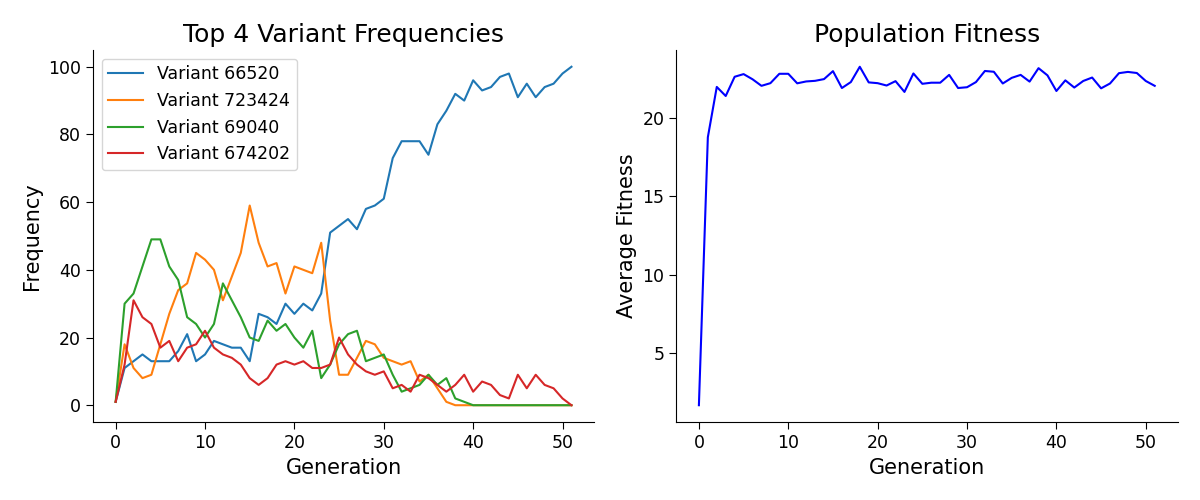

In [6]:
fitness_hist = evolutionary_simulation(
    num_receptors=20, slct_temp=5.0, random_init=False,
    num_generations=100, has_mutation=False, cost=1, reward=1,
    population_size=100, hard_mode=True, stop_at_converged=True,
    num_food_items =2, num_non_food_items=20, seed=12)

So the simulation above worked well... perhaps. With 20 receptors, there are $2^{20} \approx  1 \text{million}$ different types to evaluate. However, our population only consisted of one hundred individuals. This process quickly selected the best variant in the existing population. But, what if there are better variants that were not in this initial population? Let's take a look at the selected variant and think about whether or not a better variant is possible.


In [7]:
# What receptors did the dominant variant have?
binary_str = bin(66520)[2:]
padded_binary_str = binary_str.zfill(20)
print(padded_binary_str)

00010000001111011000


Comparing this receptor pattern to the food and non-food markers used in the simulation above we see that this pattern will cause the organism to always strike at one of the food items (the one with marker 10110100111111111111) but not the other, and to strike at just two of the ten possible non-food items. So it will avoid most false positive strikes, but miss out on half of the food opportunities. Looking at the food and non-food markers in the simulation above we can see that an organism with receptors 00000000001111111111 will have perfect discrimination between food and non-food items. However this 'best' variant was not in the initial population and a purely selective process will never generate novel better variants. We need a way of introducing variation into the population. We need mutation.

## Simulation: Selection Acting on a Population with Mutation
Run the cell below to see a similar evoluationary process play out again, but this time with mutation.


Population size: 100
Food markers:


array([[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

Non-food markers:


array([[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 0,

Reward: 1
Cost: 1
Food frequency: 0.5
---------------------------------------


Simulating Generations:   0%|          | 0/200 [00:00<?, ?it/s]

Average mean population fitness for the last 10% of rounds: 42.7145


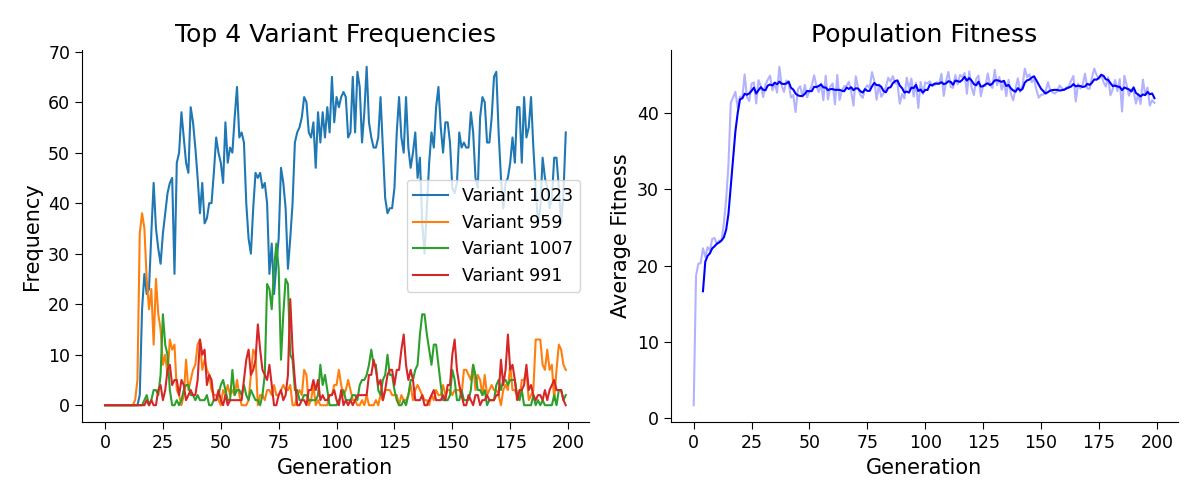

In [8]:
fitness_hist = evolutionary_simulation(
    num_receptors=20, slct_temp=5.0, random_init=False,
    num_generations=200, has_mutation=True, mutation_rate=0.02,
    population_size=100, hard_mode=True, n_trials=100, cost=1, reward=1,
    num_food_items =2, num_non_food_items=20, seed=12, stop_at_converged=False)

In [9]:
# This was the receptor pattern of the dominant variant
binary_str = bin(1023)[2:]
padded_binary_str = binary_str.zfill(20)
print(padded_binary_str)

00000000001111111111


Mutation effectively introduced variation, allowing the parameter space to be searched more thoroughly. The mean population fitness stabilized around 42.7 after this simulation, compared to approximately 22.4 in the previous simulation without mutation. But can we do better? Unfortunately, we can't assume that just because this is the output of an evolutionary process, we have reached some kind of globally optimal solution. (Although in this case by inspecting the problem we can conclude that our evolutionary process with mutation did indeed find the best solution in this instance). One important reason for this is because evolution is effectively a hill climbing algorithm. Mutations make small steps in the genotype-parameter space, and if these mutations prove beneficial (which they often don't), they are more likely to be retained in subsequent generations (this is selection). These beneficial mutations then become the basis for further exploration of the genotype-parameter space through additional mutations. But, there is always the possibility that there is some really great solution that was not reachable by an 'adaptive path' of mutations.



## Simulation: Selection Caught in a Local Optimum
Consider a scenario where two peaks represent local optima in the fitness landscape. These peaks are separated by a 'maladaptive valley,' a region of lower fitness. An evolving population that starts near one of these peaks would likely climb toward that local optimum due to natural selection favoring incremental improvements. However, reaching the higher peak on the other side of the valley would require a sequence of mutations that initially decrease fitness before eventually leading to a much higher fitness level. In such cases, natural selection would typically weed out these 'stepping-stone' mutations before they could lead to the higher peak, causing the population to get stuck at the lower local optimum. We can see just such an example of this scenario play out the simulation below.

In [ ]:
fitness_hist = evolutionary_simulation(
    num_receptors=3, slct_temp=5.0, random_init=False,
    num_generations=1000, has_mutation=True, mutation_rate=0.0001,
    population_size=100, seed=12,
    cost=1.0, reward=2.0, food_freq=0.5,
    food_markers=np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]]),
    non_food_markers=np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
    initial_variant=np.array([1, 1, 1], dtype=np.bool_), stop_at_converged=False)

using given food markers
Population size: 100
Initial variant: [ True  True  True]
Food markers:


array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0]])

Non-food markers:


array([[1, 1, 0],
       [1, 0, 1],
       [0, 1, 1]])

Reward: 2.0
Cost: 1.0
Food frequency: 0.5
---------------------------------------


Simulating Generations:   0%|          | 0/1000 [00:00<?, ?it/s]

Average mean population fitness for the last 10% of rounds: -0.0120


In this example, the population starts out completely dominated by the all receptors '111' (aka variant 7). None of the food items ('001', '010', '100') trigger a strike for this variant, nor do any of the non-food items ('011', '101', '110'). As a result, this variant never strikes and neither gains nor loses fitness from the strike/no-strike aspect of their life, they get a score of zero. Occasionally, mutation introduces a new variant, but over the course of the thousand generations in the simulation, all of these are 1-bit mutants. While these mutants still don't strike at any of the food items, they do strike at one of the non-food items, incurring a cost of $c$ in one-sixth (half of the scenarios are non-food items and one-third of those are the specific non-food item that a particular mutant will strike). Because these mutants have lower fitness than the dominant type they are swiftly removed from the population by selection.

Yet, there is a better solution. In this example, the reward for successful strikes is $r=2$, which is greater than the cost $c=1$ of striking non-food items. Given that food and non-food items are equally likely to be encountered, striking at everything results in positive expected fitness increment. This makes it a better strategy than striking at nothing, which has an expected reward of zero. However, in the simulation above, our process couldn't reach this superior solution. This is because these local optima in the fitness landscape were separated by a so-called 'fitness valley,' and there was no 'adaptive path' bridging them.

In [ ]:
# @markdown **Run this cell** to visualize the 3 marker/receptor genotype space and the 'fitness valley' of this particular example.
def one_bit_difference(node1, node2):
    """Check if two nodes have a 1-bit difference."""
    return sum(a != b for a, b in zip(node1, node2)) == 1

# Create a new graph
G = pgv.AGraph(strict=True)

# Add nodes for food types and non-food types
nodes = [[0, 0, 0],
         [1, 0, 0], [0, 1, 0], [0, 0, 1],
         [1, 1, 0], [1, 0, 1], [0, 1, 1],
         [1, 1, 1]]


positions = {
    str([0, 0, 0]): "0,1",
    str([1, 0, 0]): "2,2",
    str([0, 1, 0]): "2,1",
    str([0, 0, 1]): "2,0",
    str([1, 1, 0]): "4,2",
    str([1, 0, 1]): "4,1",
    str([0, 1, 1]): "4,0",
    str([1, 1, 1]): "6,1"
    }


for node in nodes:
    if node in [[1, 0, 0], [0, 1, 0], [0, 0, 1]]:
        G.add_node(str(node), label=str(node), color="red", pos=positions[str(node)], pin=True)
    elif node in [[1, 1, 0], [1, 0, 1], [0, 1, 1]]:
        G.add_node(str(node), label=str(node), color="red", pos=positions[str(node)], pin=True)
    else:
        G.add_node(str(node), label=str(node), color="blue", pos=positions[str(node)], pin=True)

G.node_attr['width'] = '1'
G.node_attr['height'] = '1'

# Add edges for nodes with 1-bit difference
for i in range(len(nodes)):
    for j in range(i, len(nodes)):
        if one_bit_difference(nodes[i], nodes[j]):
            G.add_edge(str(nodes[i]), str(nodes[j]))

# Save the graph to a PNG file
filename = "evolution_graph.png"
G.layout(prog='neato')
G.draw(filename, format='png')

# Display the PNG file using Image
Image(filename)

The blue nodes in the genotype space represent local optima of the fitness function, while the red nodes depict the fitness valley that separates them.

## Math Exercise: Calculating Expected Fitness Score

The expected fitness value of genotype '000', which strikes at everything, is calculated as:
$$\text{# trials} \cdot (\text{food frequency} \cdot r + (1 - \text{food frequency}) \cdot c) = 100 \cdot (0.5 \cdot 2 - 0.5 \cdot 1) = 50$$
Similarly the expected fitness value of genotype '111', which strikes at nothigh is calculated as 0.

1. Calculate the expected fitness for the 1-bit genotypes ('100', '010', '001') situated in the 'fitness valley'. These all have the same expected fitness, since they strike at one of the three food items, and two of the three non-food items. Recall each food item and non-food item is equally likely to be the item present in a given trial.
  
2. Calculate the expected fitness for the 2-bit genotypes ('110', '101', '011') located in the 'fitness valley'. Again, they all share the same expected fitness, striking at none of the three food items, but one of the three non-food item. Again, each food item and non-food item having an equal likelihood of being the item present in a given trial.

**Answers**

1. $100 \cdot(\frac{1}{6} \cdot 2 - \frac{2}{6} \cdot 1) = 0$
2. $100 \cdot ( 0 + \frac{-1}{6}) \approx -16.67$)

<details>
  <summary>Click to see the answers</summary>
  <ol>
    <li>$$100 \cdot \left(\frac{1}{6} \cdot 2 - \frac{2}{6} \cdot 1\right) = 0$$</li>
    <li>$$100 \cdot \left(0 + \frac{-1}{6}\right) \approx -16.67$$</li>
  </ol>
</details>

## Simulation: Traversing the Fitness Valley with More Mutation
One way to traverse such fitness valleys is by increasing the mutation rate, enabling the population to explore more widely. In the simulation above, with the mutation rate set at $\mu=0.0001$, mutants differing from the dominant type by more than one bit were extremely rare (i.e., they didn't appear during our 1,000-generation simulation). Now, when we increase the mutation rate, in the simulation below we see that crossing this 'valley' becomes much more feasible.

In [ ]:
fitness_hist = evolutionary_simulation(
    num_receptors=3, slct_temp=5.0, random_init=False,
    num_generations=400, has_mutation=True, mutation_rate=0.01,
    population_size=100, num_food_items =1, num_non_food_items=2, seed=12,
    cost=1.0, reward=2.0, food_freq=0.5,
    food_markers=np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]]),
    non_food_markers=np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
    initial_variant=np.array([1, 1, 1], dtype=np.bool_), stop_at_converged=False)

Cranking up the mutation worked, in this case. Can mutation be too high though? Let's increase the mutation rate in the next simulation to $\mu=0.1$ and see what happens.

In [ ]:
fitness_hist = evolutionary_simulation(
    num_receptors=3, slct_temp=5.0, random_init=False,
    num_generations=400, has_mutation=True, mutation_rate=0.1,
    population_size=100, num_food_items =1, num_non_food_items=2, seed=12,
    cost=1.0, reward=2.0, food_freq=0.5,
    food_markers=np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]]),
    non_food_markers=np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
    initial_variant=np.array([1, 1, 1], dtype=np.bool_), stop_at_converged=False)

With this higher mutation rate we observe that even though the optimal variant is identified, the high mutation rate results in a decrease in overall population fitness. In this simulation the mean population fitness is approximately 35.9, significantly lower than the expected fitness score of 50 for the best variant. This hints at a fundamental trade-off between exploration (seeking new solutions) and exploitation (utilizing current best solutions). Low mutation rates can trap the evolutionary process in suboptimal local fitness peaks, hindering the discovery of superior solutions. However, a high mutation rate reduces overall fitness, since mutations typically deviate from an already effective genotype. With this in mind, let's look a little more formally at how evolution can (and can't) be thought of as fitness optimization process.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 1.2.3.3: How Evolution 'Optimizes' Fitness  


Because of selection, the population's dominant genotype is more likely to shift toward regions of higher fitness. Over time, this leads to populations typically being found in these high fitness regions, which explains the highly adapted traits observed in nature. In this sense both real-world evolutionary processes and the simulated versions we've explored can be thought of optimization algorithms finding good parameters for a fitness function. But there are some key differences. One such key difference is that evolution has no termination condition. Evolution doesn't stop when a 'good enough' or 'best' solution is reached because the process is blind to the overall structure of the problem being solved. So, even after stumbling upon a 'good' solution, mutations continue, and they mostly end up being counterproductive. When a complicated and efficient system is working well, most changes will make things worse!

This is somewhat at odds with our observations last chapter where normative evolutionary thinking was used to explain the observation of many adaptive behaviours and traits out in the natural world. How can an ongoing restless process like evolution result in highly adapted organism?

The answer lies in the dynamic properties of evolutionary processes. With enough selection pressure, evolution exhibits 'sticky attractors' within the landscape of genetic possibilities. These are states that, once attained, tend to be stable over long periods, even amidst ongoing mutations. The 'stickiness' of these attractors means that, despite continuous evolution, populations tend to remain within these high-fitness states.

This discussion above, while illustrative, is somewhat abstract. To make this argument more concrete we will need to focus on a specific well defined system. Let's start.

Consider a genotype space denoted $G$, consisting of sequences of bits of length $n$. There's a fitness function $f(g): G \rightarrow \mathbb{R}$ that maps each genotype $g$ in $G$ to a real number representing its fitness. For the sake of simplicity, we'll assume that fitness depends solely on an individual's genotype, not on the genotypes of others in the population, or the genotypes present in other evolving population, and that this function (which represents the environment) remains constant throughout the process. We will address changing fitness functions and fitness function that depend on the genotype of other individuals later in this chapter.

For analytic simplicity, let's further assume that selection pressure is strong and mutation rates are low. This leads to two significant effects: the population is generally dominated by a single variant, and given the rarity of mutations, we need only consider whether a new mutant can supplant the current dominant variant to understand the long-term dynamics of this evolutionary process. This method of analysis, sometimes known as 'mutant invasion analysis', is a cornerstone of quantitative genetics and evolutionary game theory [further reading].

By setting the mutation rate low in our simulation we can see these two effects in action.

In [ ]:
# Simulation with low mutation rate and strong selection
fitness_hist = evolutionary_simulation(
    num_receptors=3, slct_temp=5.0, random_init=False,
    num_generations=600, has_mutation=True, mutation_rate=0.0001,
    population_size=100, num_food_items =1, num_non_food_items=2, seed=12,
    cost=1.0, reward=1.0, food_freq=0.5,
    food_markers=np.array([[1, 1, 1]]),
    non_food_markers=np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]]),
    initial_variant=np.array([0, 0, 0], dtype=np.bool_), stop_at_converged=False)

Because we assume mutations are rare and selection is strong we can focus our analysis on the probability of our evolutionary process transitioning from a population with dominant variant $g$ to one with dominant variant $g'$. This transition probability is the product of two factors:
1. The probability of a mutant type $g'$ arising in a population where $g$ is dominant.
2. The fixation probability, $\phi(g, g')$, which is the probability of $g'$ becoming the dominant variant once introduced by mutation.

First let's consider the probability of a mutant arising. Given a per-bit mutation rate, $\mu$, a genome length of $n$ bits, and a population size $N$, we can calculate:
* Probability of no mutants showing in a generation: $$(1-\mu)^{n \cdot N}$$
* Probability of exactly one 1-bit mutant in a generation: $$N \cdot [n \cdot \mu \cdot (1-\mu)^{n-1}] \cdot (1-\mu)^{n \cdot(N-1)}$$
* Probability of more than one mutant, or a mutant with a multi-bit mutation, or some combination of these events: $$1 - N \cdot [n \cdot \mu \cdot (1-\mu)^{n-1}] \cdot (1-\mu)^{n \cdot(N-1)} - (1-\mu)^{n \cdot N}$$

For example, with $\mu = 1 \times 10^{-6}$, $N=100$ and $n=4$ then the probability of no mutants in a generation is about 99.96%, and the probability of a single, 1-bit mutant is approximately 0.04%. More complex events have an effectively negligible probability of occurring. Being able to effectively ignore complex mutation events is what the 'rare mutation' assumption is about. The time between appearances of mutant variants will follow a Poisson distribution with new mutant variants being introduced every 2501 generations on average for these example parameters. We also assume that selection is sufficiently strong, so that a new mutant variant will likely either dominate or be eliminated before another mutation event occurs. Not having to consider multiple mutants invading at the same time is one of the things that our 'sufficiently strong' selection assumption is about.

Next, the fixation probability $\phi(g, g')$ will depend on the fitness function $f$, population size, and selection strength. For simplicity, we assume selection is so strong that less fit mutants can never become dominant, i.e. $\phi(g,g') \approx 0$ when $f(g) > f(g')$ and $\phi(g, g') > 0$ when $f(g) \leq f(g')$.

Given this, the long term dynamics of our evolutionary process can be closely approximated by a Markov process with transition probabilities given by the transition matrix $P$. $P_{ij}$, the element in the $i^{th}$ row and the $j^{th}$ column of $P$ gives the probability of transitioning from the state indexed by $j$ into state indexed by $i$. Considering $g$ and $g'$ are unique bit strings, we can assign them natural numerical representations. The transition probabilities are then

$$P_{g'g} =
\begin{cases}
\frac{1}{n} \phi(g, g') & \text{if } g' \in \Gamma(g) \\
0 & \text{if } g' \notin \Gamma(g) \text{ and } g \neq g' \\
1 - \frac{1}{n}\sum\limits_{g' \in \Gamma(g)} \phi(g,g') & \text{if } g = g'
\end{cases}$$

Here, $\Gamma(g)$ represents all sequences that differ from $g$ by exactly one bit. (The number of bit differences between two binary sequences is known as the Hamming distance.)

In the theory of Markov processes an absorbing state is one that, once entered, cannot be left. Because of our assumption of strong selection our Markov process has such absorbing states and these correspond precisely to local maxima of the fitness function $f$. This simplifies our understanding of the long-term behavior of the evolutionary process. Specifically, over an infinitely long time horizon, the population will almost surely end up in one of these local optima and remain there. In other words, the absorbing states serve as 'sinks' that capture the evolutionary trajectory. This helps to explain why even though evolution is an ongoing process and blind to the underlying structure of the fitness function, it nevertheless often settles in at local optima of the fitness function. It is in this sense that the evolutionary process can be viewed as an optimization algorithm, and one that is guaranteed (under certain conditions, using the theory of Markov processes) to converge on local fitness maxima. Note though there are no guarantees about how these local fitness maxima related to the global maxima. This is because evolution is essentially a local 'hill-climbing' process with no awareness of the global shape of the fitness landscape. Its only awareness is of the smear of points in the genotype space that the population is currently able to sample, i.e. those points close enough to the dominant variant(s) given the mutation process.

In this argument that links absorbing states to local fitness optima—hinging on our assumption that $\phi(g,g') \approx 0$ when $f(g) > f(g')$ and $\phi(g, g') > 0$ when $f(g) \leq f(g')$—we are not able to say much about which optima the evolutionary process will end up in using this analysis. In the appendix we present a more nuanced version of this argument. It uses a weaker assumption where less fit mutants do have a small, but non-negligible probability of becoming dominant, i.e. $0 < \phi(g,g') < \epsilon$ when $f(g) > f(g')$ and $\phi(g, g') \geq \epsilon$ when $f(g) \leq f(g')$. This allows for exploration of how the details of the genotype space (and in particular the geometry of that space induced by the mutation process) together with the fitness function determine which states an evolutionary process is likely to spend most of its time in.

This concludes our introduction to the evolutionary process. In the remainder of this chapter we will:
1. See how sex and recombination radically enhance the ability of an evolutionary process to discover good variants in vast genotype spaces.
2. Get a richer sense of the ways that evolution **is not** optimization. Specifically we will develop an appreciation for the fact that the precise fitness function 'being optimized' is typically is a moving target, shifting from one generation to the next, often due to the very evolutionary changes the fitness function is driving.
3. Explore the importance of within lifetime learning, both as a response to rapid environmental change within an individual's lifetime, but also as an accelerator of the evolutionary process.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

# Quiz

In [ ]:
# @markdown **Run this cell** to take the quiz
# @markdown **Run this cell** to take the quiz
comprehension_quiz = [
  {
    "question": "What is the impact of mutation on the evolutionary process?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "It always increases the fitness of individuals in a population.",
        "correct": False,
        "feedback": "Mutation does not always increase fitness; it typically introduces neutral or deleterious variations. Beneficial mutations are rare."
      },
      {
        "answer": "It introduces necessary variation to explore new genotypes.",
        "correct": True,
        "feedback": "Correct! Mutation is essential for introducing genetic variation, which allows populations to explore new genotypes and adapt over time."
      },
      {
        "answer": "It decreases genetic diversity within a population.",
        "correct": False,
        "feedback": "Mutation actually increases genetic diversity by introducing new genetic variations."
      },
      {
        "answer": "It reduces the population size over time.",
        "correct": False,
        "feedback": "Mutation itself does not necessarily reduce population size; it's the selection process that might influence population numbers based on the fitness effects of mutations."
      }
    ]
  },
  {
    "question": "How does evolution compare to a typical optimization algorithm?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "Evolution has a clear termination condition when a global maximum is reached.",
        "correct": False,
        "feedback": "Evolution lacks a termination condition and does not stop even when high-fitness solutions are found."
      },
      {
        "answer": "Evolution is a process that continually explores and exploits, without awareness of the global fitness landscape.",
        "correct": True,
        "feedback": "Exactly! Evolution continuously explores new genotypes and exploits current adaptations without a concept of the overall fitness landscape. In this way it is like a 'black-box' optimization algorithm"
      },
      {
        "answer": "Evolutionary processes always find the globally optimal solution.",
        "correct": False,
        "feedback": "Evolution does not necessarily find global optima; it often settles on local maxima due to its hill-climbing nature."
      },
      {
        "answer": "Evolution stops mutations once a sufficiently good solution is found.",
        "correct": False,
        "feedback": "Evolution does not stop mutating genotypes even after finding high-fitness solutions, which can lead to further, fitness reducing variation."
      }
    ]
  },
  {
    "question": "In the context of evolutionary simulations, what does a low mutation rate typically lead to?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "A diverse population with many different genotypes coexisting.",
        "correct": False,
        "feedback": "A low mutation rate usually results in less genetic diversity, not more."
      },
      {
        "answer": "Rapid convergence to the global fitness peak.",
        "correct": False,
        "feedback": "Low mutation rates can lead to rapid convergence, but not necessarily to global peaks—often to local ones."
      },
      {
        "answer": "The population is generally dominated by a single variant.",
        "correct": True,
        "feedback": "Correct! Low mutation rates can lead to populations being dominated by a single, high-fitness variant."
      },
      {
        "answer": "An increase in the number of harmful mutations.",
        "correct": False,
        "feedback": "A low mutation rate means fewer mutations overall, not an increase in harmful ones specifically."
      }
    ]
  },
  {
    "question": "What role do 'sticky attractors' play in evolutionary processes?",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "They prevent the population from reaching any kind of fitness peak.",
        "correct": False,
        "feedback": "Sticky attractors do not prevent the attainment of fitness peaks; they are the peaks where populations tend to stabilize."
      },
      {
        "answer": "They represent states of low fitness that populations tend to avoid.",
        "correct": False,
        "feedback": "Sticky attractors are not low-fitness states; they are high-fitness states that populations are drawn to."
      },
      {
        "answer": "They are high-fitness states in the genotype space that populations are likely to remain in for long periods.",
        "correct": True,
        "feedback": "Exactly! Sticky attractors are robust high-fitness states where populations tend to remain stable over time."
      },
      {
        "answer": "They are synonymous with global maxima in the fitness function.",
        "correct": False,
        "feedback": "Sticky attractors correspond to local maxima, not necessarily global maxima, in the fitness landscape."
      }
    ]
  }
]

display_quiz(comprehension_quiz)